In [1]:
import re
import yaml
import logging
import sys

import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import dask.dataframe as dd

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2


In [2]:
#import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(stream=sys.stdout)
handler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(funcName)s: %(levelname)s] %(message)s'))
logger.addHandler(handler)

Read file (`read_csv`) and access (`head` / `tail`) operations were tested on datasets of the size 0.5, 1.0, 1.5 and 2.0 Gb on local machine using Pandas and Dask libraries

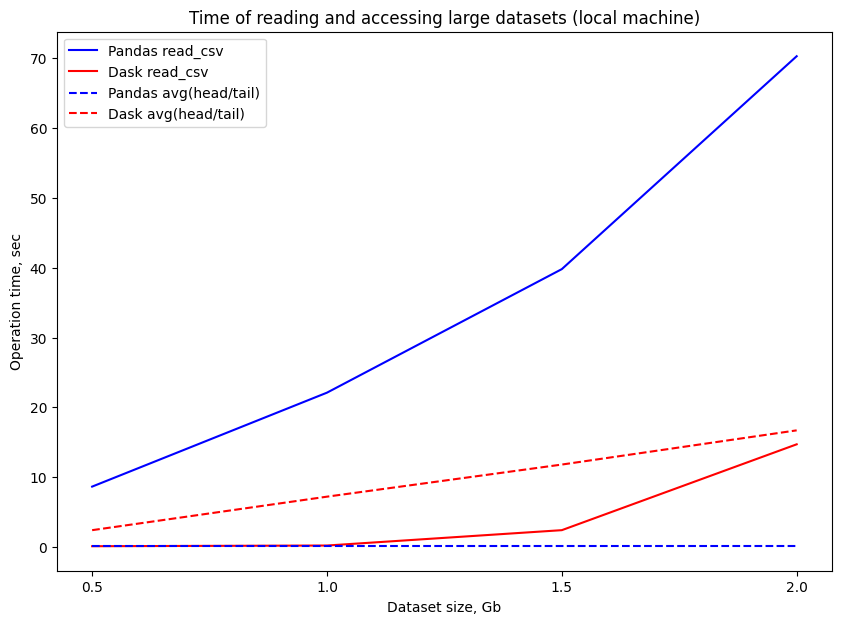

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot([0.5, 1.0, 1.5, 2.0], [8.64, 22.1, 39.8, 70.3], 'b-', label='Pandas read_csv')
ax.plot([0.5, 1.0, 1.5, 2.0], [0.1, 0.2, 2.4, 14.7], 'r-', label='Dask read_csv')
ax.plot([0.5, 1.0, 1.5, 2.0], [0.2, 0.2, 0.2, 0.2], 'b--', label='Pandas avg(head/tail)')
ax.plot([0.5, 1.0, 1.5, 2.0], [2.4, 7.2, 11.8, 16.7], 'r--', label='Dask avg(head/tail)')
ax.legend()
ax.set_ylabel('Operation time, sec')
ax.set_xlabel('Dataset size, Gb')
ax.set_xticks([0.5, 1.0, 1.5, 2.0])
ax.set_title('Time of reading and accessing large datasets (local machine)');

Here we can see the difference between Pandas and Dask packages performing file read and data access operations.  
Pandas is winning in data access time as long as the dataset fits into RAM. But time of reading large files rises  significantly as the dataset size grows.  
Dask demonstrates less significant dependency between the size of the dataset and data read and accesss time but for the price of increased data access time.

In [3]:
%%writefile config.yaml

file_ext: csv
input_name: d:\Work\Programming\DataAnalysis\GlobalLandTemperaturesByCity_x1
output_name: d:\Work\Programming\DataAnalysis\temperaturesbycity_verified
input_delimiter: ","
output_delimiter: "|"
cols_expected:
    - dt
    - AverageTemperature
    - City
    - Country
    - Latitude
    - Longitude
cols_validated: 
    - dt
    - avg_temp
    - city
    - country
    - latitude
    - longitude

Overwriting config.yaml


In [10]:
%%writefile ingest_utils.py
import logging
import os
import pandas as pd
import yaml
import re
import sys

# Setting up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(stream=sys.stdout)
handler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(funcName)s: %(levelname)s] %(message)s'))
logger.addHandler(handler)

def get_config(file):
    try:
        with open(file, 'r') as f:
            return yaml.safe_load(f)
    except yaml.YAMLError as exc:
        logger.error(exc)
        return None


def re_replace(string, pattern, repl):
    return re.sub(pattern, repl, string)


def validate_columns(df, config):
    cols_expected = list(config['cols_expected'])
    cols_expected = [x.lower() for x in cols_expected]
    cols_output = list(config['cols_validated'])
    
    map_col_names = {cols_expected[i]: cols_output[i] for i in range(len(cols_expected))}

    cols_received = df.columns.str.lower()
    cols_received = [x.lower().strip() for x in cols_received] # lower case and strip leading and trailing whitespaces
    cols_received = [re.sub(r'\s+', r'_', x) for x in cols_received] # replacing 1 or more whitespaces in the middle of column name by '_'

    df.columns = cols_received

    cols_valid = [x for x in cols_received if x in cols_expected] # check if cols_valid are in list of expected columns
    cols_to_drop = [x for x in cols_received if x not in cols_expected]
    # check if number of found columns equals number of expected columns (but not sure that all columns are presented)
    if set(cols_valid) != set(cols_expected):
        logger.error('Validation FAILED: Not all expected columns found! Missing columns: ', set(cols_expected).difference(set(cols_valid)))
        return 0

    # replace received column names by valid ones based on map dictionary
    for i, colname in enumerate(cols_valid):
        cols_valid[i] = map_col_names[colname]

    df.drop(columns=cols_to_drop, inplace=True)
    df.columns = cols_valid
    logger.debug('Validation PASSED: all expected columns found')
    return 1


Overwriting ingest_utils.py


In [5]:
import ingest_utils as utils
config = utils.get_config('config.yaml')
print(config)

{'file_ext': 'csv', 'input_name': 'd:\\Work\\Programming\\DataAnalysis\\GlobalLandTemperaturesByCity_x1', 'output_name': 'd:\\Work\\Programming\\DataAnalysis\\temperaturesbycity_verified', 'input_delimiter': ',', 'output_delimiter': '|', 'cols_expected': ['dt', 'AverageTemperature', 'City', 'Country', 'Latitude', 'Longitude'], 'cols_validated': ['dt', 'avg_temp', 'city', 'country', 'latitude', 'longitude']}


In [6]:
df = pd.read_csv(config['input_name']+'.'+config['file_ext'], delimiter=config['input_delimiter'], index_col=0)
#df = dd.read_csv(config['input_name']+'.'+config['file_ext'])

In [7]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [8]:
utils.validate_columns(df, config)

1

In [9]:
df.head()

,dt,avg_temp,city,country,latitude,longitude
0,1743-11-01,6.068,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,Århus,Denmark,57.05N,10.33E


In [14]:
df.to_csv(config['output_name']+'.csv.gz', sep=config['output_delimiter'], compression='gzip')

Created file contains:  
rows: 8 599 212
columns: 7
size (pure .csv format): 0.51 Gb
size (.csv compressed by gzip): 0.07 Gb